In [1]:
import os
import sys
import nashpy
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

import multiprocessing
from joblib import delayed
from joblib import Parallel

In [2]:
# ASSUMPTIONS
    # [1] Performance Evaluation in Misbehaviour Detection Techniques for DoS Attacks in VANETs
C = 6000 # [1]
w = 0.5
gm = 0.5
v0 = 130 # (*) highway speed in ITALY
lambda_pois = 3000

In [216]:
def payoff_attack(atk_rate, atk_tau, atk_C, atk_o, atk_g, atk_v0, atk_v1, atk_lbd):
    
    if stats.poisson.cdf(k = atk_tau, mu = atk_lbd) > 0.5:
        rt = atk_rate
    else:
        rt = 0
    
    #const_ = 1/(tau/C)
    
    
    part1 = (rt/atk_tau) - atk_o - atk_g
    ### part1 = (atk_tau/atk_C)*(rt/atk_C) - atk_o - atk_g
    delta_v = np.exp(((atk_v0 - atk_v1) / atk_v0)) - 1
    
    return (part1 + delta_v)#.astype(np.float32)

payoff_attack = np.vectorize(payoff_attack)

In [168]:
def payoff_defense(def_rate, def_tau, def_C, def_v0, def_v1, def_lbd):
    
    if stats.poisson.cdf(k = def_tau, mu = def_lbd) > 0.5:
        rt = def_rate
    else:
        rt = 0
    
    delta_v = ((def_v0 - def_v1) / def_v0)
    part1 = 1 - ((def_tau/def_C)*(rt/def_C))
    part2 = ((def_tau/def_C) - (1/2))**2 # performance of VANET
    
    # Scaling
    #minimum = max(part1, delta_v)
    #maximum = min(part1, delta_v)
    
    #part1 = (part1 - minimum)/(maximum - minimum)
    #delta_v = (delta_v - minimum)/(maximum - minimum)    
    
    return part1 - part2 - delta_v#.astype(np.float32) # a-b-c

payoff_defense = np.vectorize(payoff_defense)

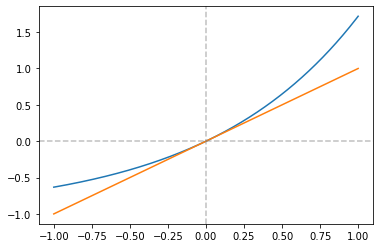

In [71]:
x = np.linspace(-1, 1, num = 1000)
plt.plot(x, np.exp(x) - 1)
plt.plot(x, x)
plt.axvline(0, color = "grey", alpha = .5, ls = "--")
plt.axhline(0, color = "grey", alpha = .5, ls = "--")


#plt.plot(x, ((x/6000)-0.5)**2, label = "$f(x)^2$")
#plt.plot(x, np.abs((x/6000)-0.5), label = "$|f(x)|$")
#plt.legend()
plt.show()

In [193]:
def Simulation(sim_C, sim_omega, sim_gamma, sim_v0, sim_rate_list = None,
               sim_tau_list = None, sim_v1_list = None, sim_poiss_mu = 50):
    """
    Parameters
    ----------
    
    sim_rate_list : iterable
    sim_tau_list : iterable
    sim_v1_list : iterable
    """
    output_payoff = []
    output_strategy = []
    
    if sim_tau_list is None:
        sim_tau_list = np.arange(200, 1001, 100)
    if sim_rate_list is None:
        sim_rate_list = np.arange(200, 1001, 100)
    if sim_v1_list is None:
        sim_v1_list = np.arange(v0 - 30, v0 + 30, 10)
    
    for v1 in sim_v1_list:

        ATK = np.array([payoff_attack(atk_rate = r, atk_tau = sim_tau_list, atk_C = sim_C,
                                      atk_o = sim_omega, atk_g = sim_gamma, atk_v0 = sim_v0,
                                      atk_v1 = v1, atk_lbd = sim_poiss_mu)
                        for r in sim_rate_list])
        DEF = np.array([payoff_defense(def_rate = r, def_tau = sim_tau_list, def_C = sim_C,
                                       def_v0 = sim_v0, def_v1 = v1, def_lbd = sim_poiss_mu)
                        for r in sim_rate_list])

        game = nashpy.Game(ATK, DEF)
        
        equilibria = []
        for eq in game.support_enumeration():
            
            iter_ = eq
            
            br_player1 = iter_[0].argmax()
            br_player2 = iter_[1].argmax()
            
            # Payoffs
            output_payoff += [[v1,
                               ATK[br_player1, br_player2],
                               DEF[br_player1, br_player2]]]            
            # Strategies
            output_strategy += [[v1, sim_rate_list[br_player1], sim_tau_list[br_player2]]]
            
    return output_payoff, output_strategy

In [15]:
def big_payoff_matrices(big_range_r, big_range_t, big_C, big_omega, big_gamma, big_v1, big_l):
    
    attacker = np.array([payoff_attack(atk_rate = r, atk_tau = big_range_t, atk_C = big_C,
                                       atk_o = big_omega, atk_g = big_gamma, atk_v0 = v0,
                                       atk_v1 = big_v1, atk_lbd = big_l)
                         for r in big_range_r])
    defender = np.array([payoff_defense(def_rate = r, def_tau = big_range_t,
                                        def_C = big_C, def_v0 = v0,
                                        def_v1 = big_v1, def_lbd = big_l)
                         for r in big_range_r])
    
    return attacker, defender

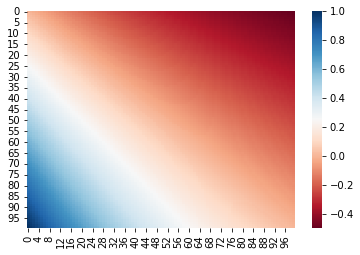

In [218]:
sns.heatmap(Z1, cmap = "RdBu");

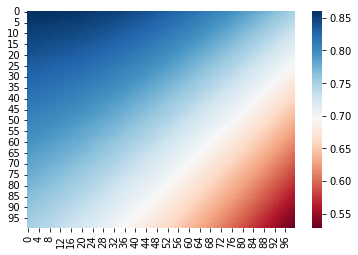

In [219]:
sns.heatmap(Z2, cmap = "RdBu");

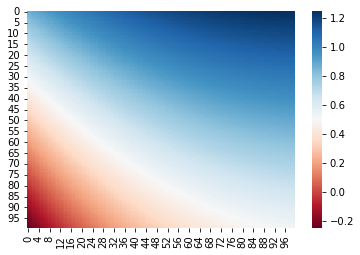

In [220]:
sns.heatmap(Z2 - Z1, cmap = "RdBu");

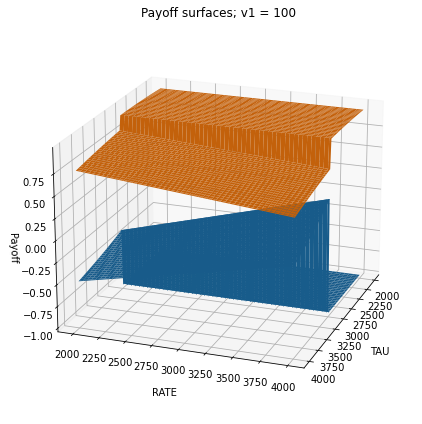

In [224]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"}, figsize = (9, 6))

X = np.linspace(2000, 4000, num = 100)
Y = np.linspace(2000, 4000, num = 100)

Z1, Z2 = big_payoff_matrices(big_range_r = X, big_range_t = Y, big_C = C,
                             big_omega = w, big_gamma = gm, big_v1 = 130,
                             big_l = 50)

X, Y = np.meshgrid(X, Y)

surf1 = ax.plot_surface(X, Y, Z1, label = "RSU")
surf2 = ax.plot_surface(X, Y, Z2, label = "attacker")

ax.set_xlabel("TAU", labelpad = 10)
ax.set_ylabel("RATE", labelpad = 10)
ax.set_zlabel("Payoff")

ax.set_title("Payoff surfaces; v1 = 100")
#ax.legend()

ax.view_init(20, 20)
plt.tight_layout()
# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

<AxesSubplot:>

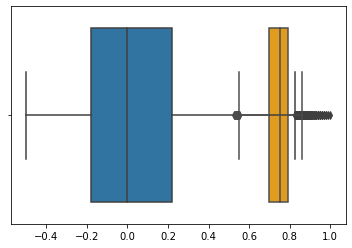

In [221]:
sns.boxplot(x = Z1.flatten())
sns.boxplot(x = Z2.flatten(), color = "orange")

In [222]:
n_cores = min(multiprocessing.cpu_count(), 8) # don't use more than 8 cores

simul = Parallel(n_jobs = n_cores)(delayed(lambda v:
                                           Simulation(sim_C = C, sim_omega = w, sim_gamma = gm, sim_v0 = v0,
                                                      sim_rate_list = np.linspace(lambda_pois - 200, # 100
                                                                              lambda_pois + 200, # 100
                                                                              num = 8, dtype = np.int32),
                                                      sim_tau_list = np.linspace(1, 6000, num = 8, # 1000, 4000
                                                                             dtype = np.int32),
                                                      sim_v1_list = [v], sim_poiss_mu = 50))(v)
                                           for v in [40, 70, 100, 130, 160, 180])

o_pfs = [simul[i][0] for i in range(len(simul))]
o_str = [simul[i][1] for i in range(len(simul))]

print(o_pfs)
print(o_str)

[[[40, 1.8642109408668421, 0.10938050213675221]], [[70, 1.4524021103279565, 0.34014973290598294]], [[100, 1.125457749073622, 0.5709189636752137]], [[130, 0.8658892128279883, 0.8016881944444445]], [[160, 0.6598118706459395, 1.0324574252136753]], [[180, 0.5466016111513736, 1.186303579059829]]]
[[[40, 3200, 1715]], [[70, 3200, 1715]], [[100, 3200, 1715]], [[130, 3200, 1715]], [[160, 3200, 1715]], [[180, 3200, 1715]]]


<AxesSubplot:>

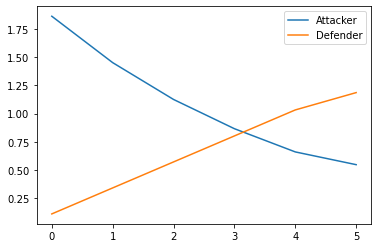

In [223]:
pd.DataFrame(np.vstack([np.array(c) for c in o_pfs]),
             columns = ["V1", "Attacker", "Defender"]).drop("V1", axis = 1).plot()

In [199]:
pd.DataFrame(np.vstack([np.array(c) for c in o_str]),
             columns = ["V1", "Attacker", "Defender"])

,V1,Attacker,Defender
0,40,3200,1715
1,70,3200,1715
2,100,3200,1715
3,130,3200,1715
4,160,3200,1715
5,180,3200,1715


---
---
---